In [1]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
import pandas as pd

In [3]:
from sklearn.model_selection import GridSearchCV

In [4]:
features_df = pd.read_csv("lda.csv")

In [5]:
def get_dataset(subject):
    X = features_df[features_df["s"] == subject].drop(columns=["y", "s"])
    y = features_df[features_df["s"] == subject]['y']
    return X, y

In [6]:
train_X, train_y = get_dataset("S2")

In [7]:
test_X, test_y = get_dataset("S1")

In [8]:
model = LDA()
grid = {'solver': ['svd']}
search = GridSearchCV(model, grid, cv=3, scoring='roc_auc')

In [9]:
X = features_df.drop(columns=["y", "s"])
y = features_df['y']

In [11]:
# search.fit(X, y)
# search.best_score_

In [12]:
search.fit(train_X, train_y)

/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'solver': ['svd']}, pre_dispatch='2*n_jobs', refit=True,
       return_train_score='warn', scoring='roc_auc', verbose=0)

In [13]:
search.best_score_

0.8823809523809524

In [14]:
search.score(test_X, test_y)

0.5616698412698412

# Find closest subjects

Correlation

In [15]:
import matplotlib.pyplot as plt

In [16]:
import numpy as np

In [17]:
features_df['y'].value_counts()

0    5250
1     750
Name: y, dtype: int64

In [18]:
channels = 8

In [197]:
def get_average(subject, attemps):
    all_events_df = features_df[
        (features_df['s'] == subject) &
        (features_df['y'] == 1)
    ].drop(columns=["y", "s"])
    
    if attemps > 0:
        all_events_df = all_events_df.sample(attemps)
    
    all_events = all_events_df.values.reshape(all_events_df.shape[0], channels, -1)
    
    return all_events.mean(axis=0).mean(axis=0)

In [198]:
def get_additional_subjects(main_subject, average):
    global averaged
    
    correlations = []
    subjects = []
    
    for subject in averaged:
        if subject == main_subject:
            continue
        subjects.append(subject)
        subject_average = averaged[subject]
        corrcoef = np.corrcoef(average, subject_average)[0][1]
        correlations.append(corrcoef)
    
    correlations = np.array(correlations)
    subjects = np.array(subjects)
    return correlations, subjects[np.argsort(-correlations)]

In [199]:
def get_dataset(main_subject, subjects, attemps):
    additional_X = features_df[features_df["s"].isin(subjects)].drop(columns=["y", "s"])
    additional_y = features_df[features_df["s"].isin(subjects)]['y']
    
    main_positive = features_df[
        (features_df["s"] == main_subject) &
        (features_df['y'] == 1)
    ].sample(attemps).index.tolist()
    main_negative = features_df[
        (features_df["s"] == main_subject) &
        (features_df['y'] == 0)
    ].sample(attemps * 7).index.tolist()
    main_indices = main_positive + main_negative
    
    main_X = features_df.loc[main_indices].drop(columns=["y", "s"])
    main_y = features_df.loc[main_indices]['y']
    
    X = pd.concat([additional_X, main_X]).reset_index(drop=True)
    y = pd.concat([additional_y, main_y]).reset_index(drop=True)
    
    test_indices = (features_df["s"] == main_subject) & (~features_df.index.isin(main_indices))
    test_X = features_df[test_indices].drop(columns=["y", "s"])
    test_y = features_df[test_indices]['y']
    
    return X, y, test_X, test_y

In [200]:
def get_roc_auc(X, y, test_X, test_y):
    model = LDA()
    grid = {'solver': ['svd']}
    search = GridSearchCV(model, grid, cv=3, scoring='roc_auc')
    search.fit(X, y)
    return search, search.score(test_X, test_y)

In [201]:
averaged = {
    'S{}'.format(i): get_average('S{}'.format(i), -1)
    for i in range(1, 6)
}

In [202]:
table = {}

In [203]:
from tqdm import tqdm_notebook

In [ ]:
for i in tqdm_notebook(range(1, 6)):
    subject = "S{}".format(i)
    
    table[subject] = {}
    
    for attemps in tqdm_notebook(range(5, 50, 5)):
        table[subject][attemps] = {}
        for i in range(3):
            table[subject][attemps][i] = []
            
            for experiment in tqdm_notebook(range(0, 10)):
                average = get_average(subject, attemps)
                _, additional_subjects = get_additional_subjects(subject, average)
                X, y, test_X, test_y = get_dataset(subject, additional_subjects[:i], attemps)
                _, roc_auc = get_roc_auc(X, y, test_X, test_y)
                table[subject][attemps][i].append(roc_auc)

/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/

/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("V

/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/

/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("V

/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("V

/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("V

/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/

/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("V

/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("V

/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("V

/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("V

/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("V

/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/

/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/noomkcalb/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False 

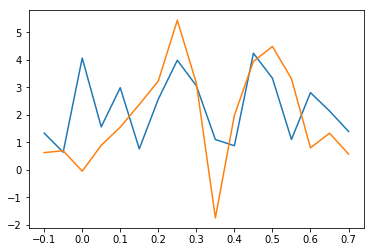

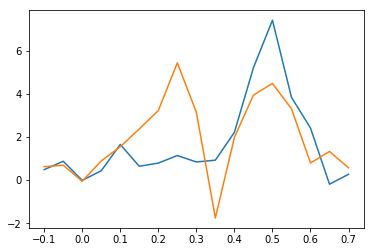

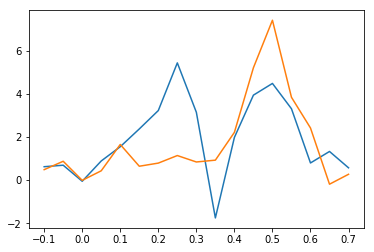

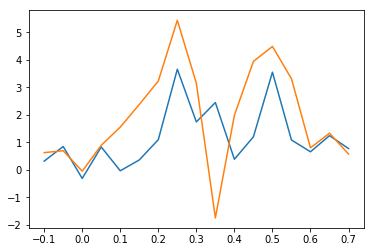

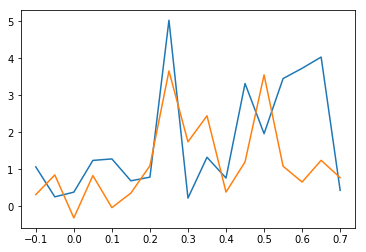

In [194]:
for i in tqdm_notebook(range(1, 6)):
    subject = "S{}".format(i)
    average = get_average(subject, -1)
    _, additional_subjects = get_additional_subjects(subject, average)
    plt.plot(np.linspace(-0.1, 0.7, 17), averaged[subject])
    plt.plot(np.linspace(-0.1, 0.7, 17), averaged[additional_subjects[0]])
    plt.show()

In [181]:
tuples = []
for i, a in table.items():
    for j, b in a.items():
        for k, c in b.items():
            tuples.append((i, j, k, np.mean([c1 for c1 in c])))

In [182]:
results_df = pd.DataFrame(tuples, columns=["subject", "attemps", "additional", "accuracy"])

In [195]:
results_df[(results_df["subject"] == "S3") & (results_df["additional"] == 1)].sort_values("attemps")["accuracy"]

7     0.542508
16    0.650843
25    0.670261
4     0.686489
13    0.690075
22    0.728992
1     0.745195
10    0.748635
19    0.729449
Name: accuracy, dtype: float64

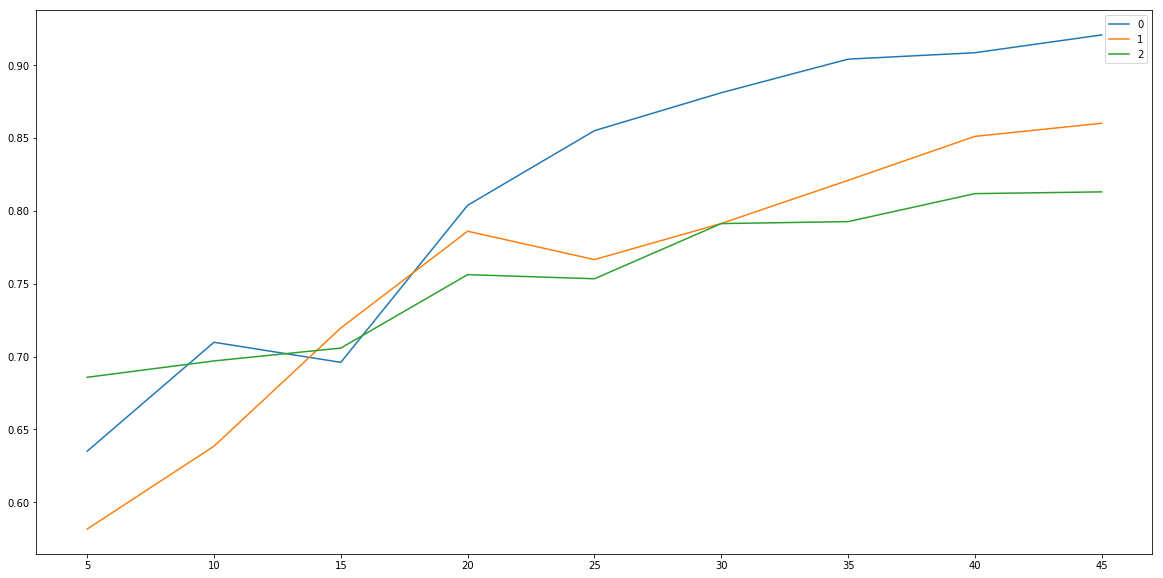

In [196]:
plt.figure(figsize=(20, 10))
subject = "S5"
for additional in range(0, 3):
    selected_results = results_df[(results_df["subject"] == subject) & (results_df["additional"] == additional)].sort_values('attemps')
    plt.plot(selected_results['attemps'], selected_results['accuracy'], label="{}".format(additional))
plt.legend()

In [ ]:
selected_results

In [ ]:
results_df.to_csv("results.csv", index=False)

Latency/Amplitude

Negative samples (p3a?)